In [80]:
# === Vehicle Detection Project ===
#
# The goals / steps of this project are the following:

# * Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
# * Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
# * Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
# * Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
# * Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
# * Estimate a bounding box for vehicles detected.




# Imports
#
#
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline



There are  8792 car images in data set
There are  8968 notcar images in data set


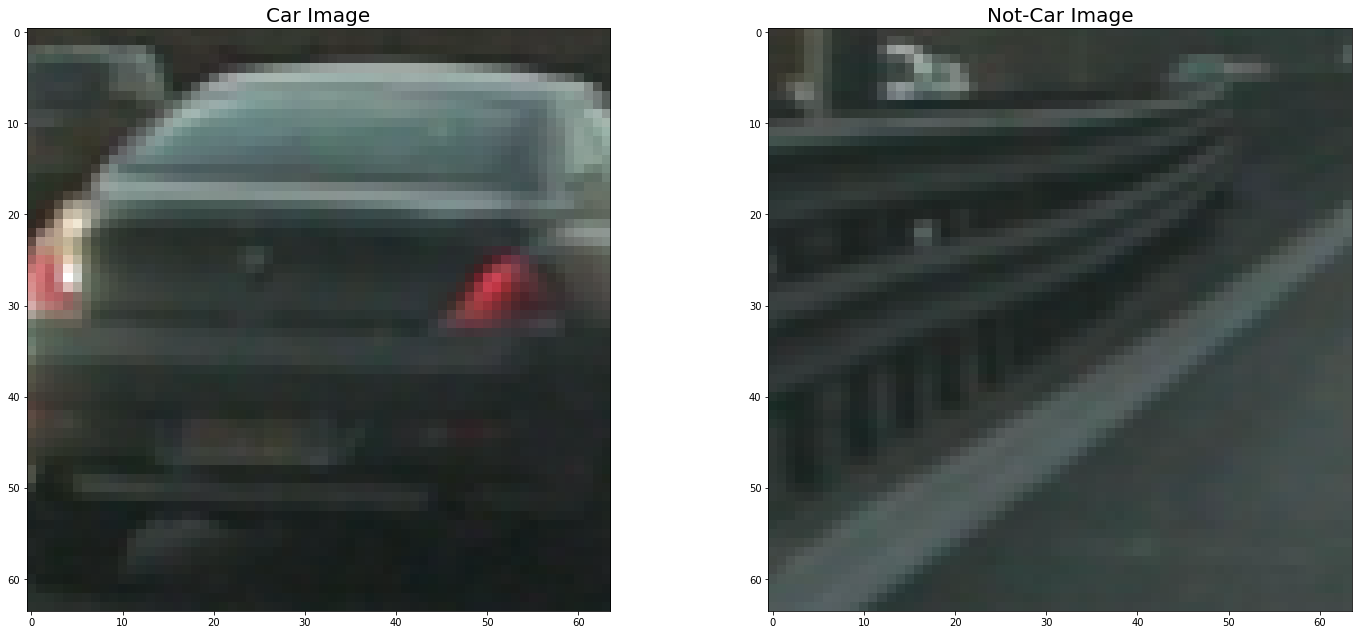

In [86]:
# This function is used to get the training data set for 
# car and notcar images. It returns two lists (car_imgs, notcar_imgs)
# containing the respective images paths

def get_car_notcar_lists():
    
    # car and notcar data directories
    car_dir = './vehicles'
    notcar_dir = './non-vehicles'
    # lists to save images paths
    car_imgs = []
    notcar_imgs = []
    
    # Walk through each folder that contains image starting at the root 
    # directories  above (vehicle_dir and non_car_dir)
    for subdir, dirs, files in os.walk(car_dir):
        for file in files:
            if file.endswith(".png"):
                full_path = os.path.join(subdir, file) 
                car_imgs.append(full_path)
        
    for subdir, dirs, files in os.walk(notcar_dir):
        for file in files:
            if file.endswith(".png"):
                full_path = os.path.join(subdir, file)
                notcar_imgs.append(full_path)
                
    return car_imgs, notcar_imgs
            
# Test function 
car_imgs,  notcar_imgs = get_car_notcar_lists()

# Print lists length           
print('There are ', len(car_imgs), 'car images in data set')
print('There are ', len(notcar_imgs), 'notcar images in data set')

# Read test images with cv2 and convert to RGB
test_car_img = cv2.cvtColor(cv2.imread(car_imgs[random.randint(0, len(car_imgs))]), cv2.COLOR_BGR2RGB)
test_notcar_img = cv2.cvtColor(cv2.imread(notcar_imgs[random.randint(0, len(notcar_imgs))]), cv2.COLOR_BGR2RGB)

# Plot random images from each set, car and not_car
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
f.tight_layout()
ax1.imshow(test_car_img)
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(test_notcar_img)
ax2.set_title('Not-Car Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

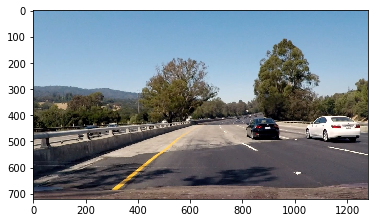

In [83]:
# This function gets random test images to use to test helper functions
# Reads images with cv2 and returns them in RGB color space

def get_test_img():
    # test image directory path
    test_imgs_dir = './test_images'
    test_imgs = []
    
    # Get all test images into a list to have them ready to display 
    for filename in os.listdir(test_imgs_dir):    
        if filename.endswith(".jpg"):
            full_path = os.path.join(test_imgs_dir, filename)
            test_imgs.append(full_path)

    # Use cv2 to open test image and convert to RGB
    test_img = cv2.imread(test_imgs[random.randint(0, 6)])
    return test_img

# test function
test_img = cv2.cvtColor(get_test_img(), cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()

In [87]:
# Helper functions 
#
# This function is used to get the hog features from an image

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist


In [88]:
# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors

In [89]:
# Train Classifier (Linear SVC)

# Define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_imgs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Car samples: ', len(car_features))
notcar_features = extract_features(notcar_imgs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

Car samples:  17584
Notcar samples:  17936
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
9.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9883


In [57]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [58]:

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [59]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

5.72 Seconds to process test images


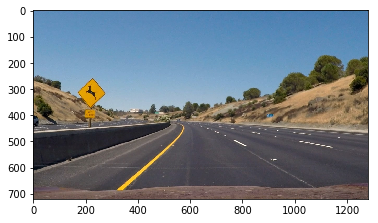

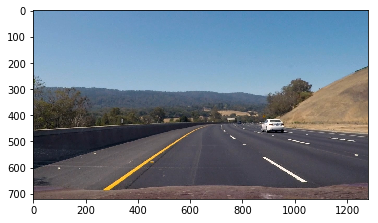

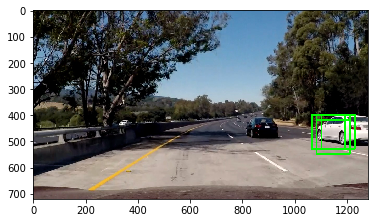

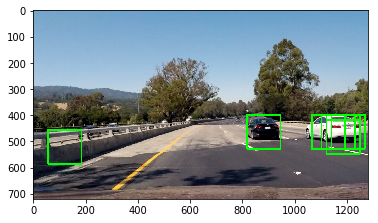

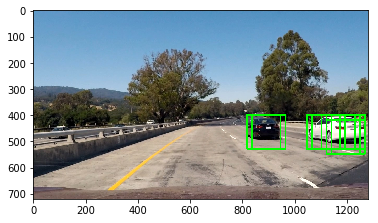

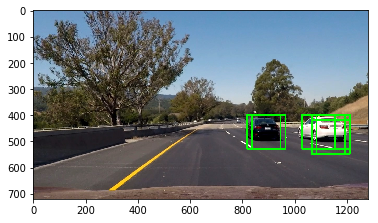

In [60]:
t=time.time() # Start time
green_color = (0, 255, 0)
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=green_color, thick=6)                    
    show_img(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')


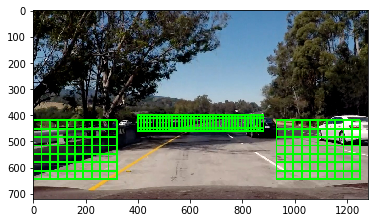

In [61]:
#image = cv2.imread('test_images/test2.jpg')
image = get_test_img()
windows = slide_window(image, x_start_stop=[930, None], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[0, 350], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=6) 
windows = slide_window(image, x_start_stop=[400, 880], y_start_stop=[400, 470], 
                    xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(0, 255, 0), thick=6)                    
show_img(window_img)

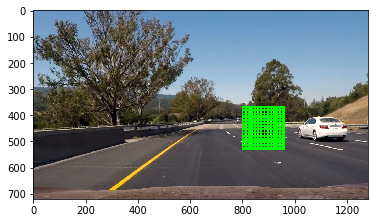

In [62]:
#image = cv2.imread('test_images/test5.jpg')
image = get_test_img()
track = (880, 450)
w_size = 80
windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-w_size,track[1]+w_size], 
                       xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=6)
windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-int(w_size),track[1]+int(w_size)], 
                       xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(0, 255, 0), thick=6)                    
show_img(window_img)

In [63]:
def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, xstart, xstop, scale, step):
    boxes = []
    draw_img = np.zeros_like(img)   
    img_tosearch = img[int(ystart):int(ystop),int(xstart):int(xstop),:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))       
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return boxes

In [38]:
#import laneline
#for image in glob.glob('test_images/test3.jpg'):
#    show_img(laneline.draw_lane(laneline.draw_lane_img_p(image)))

In [65]:
from scipy.ndimage.measurements import label

THRES = 3 # Minimal overlapping boxes
ALPHA = 0.75 # Filter parameter, weight of the previous measurements

#image = cv2.imread('test_images/test5.jpg')
image = get_test_img()
track_list = []#[np.array([880, 440, 76, 76])]
#track_list += [np.array([1200, 480, 124, 124])]
THRES_LEN = 32
Y_MIN = 440

heat_p = np.zeros((720, 1280)) # Store prev heat image
boxes_p = [] # Store prev car boxes
n_count = 0 # Frame counter

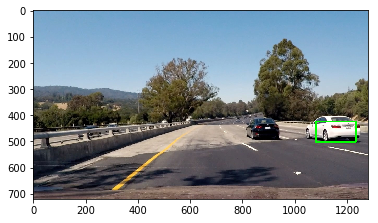

In [69]:
# Adds heat map
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap # Return updated heatmap
    
def apply_threshold(heatmap, threshold): # Zero out pixels below the threshold in the heatmap
    heatmap[heatmap < threshold] = 0 
    return heatmap 

def filt(a,b,alpha): # Smooth the car boxes
    return a*alpha+(1.0-alpha)*b

def len_points(p1, p2): # Distance beetween two points
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def track_to_box(p): # Create box coordinates out of its center and span
    return ((int(p[0]-p[2]),int(p[1]-p[3])),(int(p[0]+p[2]), int(p[1]+p[3])))


def draw_labeled_bboxes(labels):
    global track_list
    track_list_l = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #img = draw_boxes(np.copy(img), [bbox], color=(255,0,255), thick=3)
        size_x = (bbox[1][0]-bbox[0][0])/2.0 #Size of the found box
        size_y = (bbox[1][1]-bbox[0][1])/2.0
        asp_d = size_x / size_y
        size_m = (size_x + size_y)/2
        x = size_x+bbox[0][0]
        y = size_y+bbox[0][1]
        asp = (y-Y_MIN)/130.0+1.2 # Best rectangle aspect ratio for the box (coefficients from perspectieve measurements and experiments)
        if x>1050 or x<230:
            asp*=1.4
        asp = max(asp, asp_d) # for several cars chunk
        size_ya = np.sqrt(size_x*size_y/asp)
        size_xa = int(size_ya*asp)
        size_ya = int(size_ya)
        if x > (-3.049*y+1809): #If the rectangle on the road, coordinates estimated from a test image
            track_list_l.append(np.array([x, y, size_xa, size_ya]))
            if len(track_list) > 0:
                track_l = track_list_l[-1]
                dist = []
                for track in track_list:
                    dist.append(len_points(track, track_l))
                min_d = min(dist)
                if min_d < THRES_LEN:
                    ind = dist.index(min_d)
                    track_list_l[-1] = filt(track_list[ind], track_list_l[-1], ALPHA)
    track_list = track_list_l
    boxes = []
    for track in track_list_l:
        #print(track_to_box(track))
        boxes.append(track_to_box(track))
    return boxes

def frame_proc(img, lane = False, video = False, vis = False):
    if (video and n_count%2==0) or not video: # Skip every second video frame
        global heat_p, boxes_p, n_count
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        boxes = []
        boxes = find_cars(img, 400, 650, 950, 1280, 2.0, 2)
        boxes += find_cars(img, 400, 500, 950, 1280, 1.5, 2)
        boxes += find_cars(img, 400, 650, 0, 330, 2.0, 2)
        boxes += find_cars(img, 400, 500, 0, 330, 1.5, 2)
        boxes += find_cars(img, 400, 460, 330, 950, 0.75, 3)
        for track in track_list:
            y_loc = track[1]+track[3]
            lane_w = (y_loc*2.841-1170.0)/3.0
            if lane_w < 96:
                lane_w = 96
            lane_h = lane_w/1.2
            lane_w = max(lane_w, track[2])
            xs = track[0]-lane_w
            xf = track[0]+lane_w
            if track[1] < Y_MIN:
                track[1] = Y_MIN
            ys = track[1]-lane_h
            yf = track[1]+lane_h
            if xs < 0: xs=0
            if xf > 1280: xf=1280
            if ys < Y_MIN - 40: ys=Y_MIN - 40
            if yf > 720: yf=720
            size_sq = lane_w / (0.015*lane_w+0.3)
            scale = size_sq / 64.0
            # Apply multi scale image windows 
            boxes+=find_cars(img, ys, yf, xs, xf, scale, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.25, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.5, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.75, 2)
            if vis:
                cv2.rectangle(img, (int(xs), int(ys)), (int(xf), int(yf)), color=(0,255,0), thickness=3)
        heat = add_heat(heat, boxes)
        heat_l = heat_p + heat
        heat_p = heat
        heat_l = apply_threshold(heat_l,THRES) # Apply threshold to help remove false positives
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat_l, 0, 255)
        plt.savefig
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        #print((labels[0]))
        cars_boxes = draw_labeled_bboxes(labels)
        boxes_p = cars_boxes
        
    else:
        cars_boxes = boxes_p
    if lane: #If we was asked to draw the lane line, do it
        if video:
            img = laneline.draw_lane(img, True)
        else:
            img = laneline.draw_lane(img, False)
    imp = draw_boxes(np.copy(img), cars_boxes, color=(0, 255, 0), thick=6)
    if vis:
        imp = draw_boxes(imp, boxes, color=(0, 255, 0), thick=2)
        for track in track_list:
            cv2.circle(imp, (int(track[0]), int(track[1])), 5, color=(255, 0, 255), thickness=4)
    n_count += 1
    return imp

img = get_test_img()
show_img(frame_proc(img, lane=False, vis=False))

In [70]:
from moviepy.editor import VideoFileClip
n_count = 0
#laneline.init_params(0.0)
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc(image, lane=False, video=True, vis=False), cv2.COLOR_BGR2RGB)

output_v = 'project_video_proc.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video project_video_proc.mp4
[MoviePy] Writing video project_video_proc.mp4


100%|█████████▉| 1260/1261 [02:13<00:00, 11.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc.mp4 

CPU times: user 3min 23s, sys: 1.28 s, total: 3min 25s
Wall time: 2min 14s


In [71]:
from moviepy.editor import VideoFileClip
n_count = 0
#laneline.init_params(0.0)
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc(image, lane=False, video=True, vis=False), cv2.COLOR_BGR2RGB)

test_output_vid = 'test_video_proc.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(test_output_vid, audio=False)

[MoviePy] >>>> Building video test_video_proc.mp4
[MoviePy] Writing video test_video_proc.mp4


 97%|█████████▋| 38/39 [00:04<00:00,  8.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_proc.mp4 

CPU times: user 6.58 s, sys: 60 ms, total: 6.64 s
Wall time: 5.51 s
